## week10: seq2seq practice
### Generating names with recurrent neural networks

This time you'll find yourself delving into the heart (and other intestines) of recurrent neural networks on a class of toy problems.

Struggle to find a name for the variable? Let's see how you'll come up with a name for your son/daughter. Surely no human has expertize over what is a good child name, so let us train RNN instead;

It's dangerous to go alone, take these:

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Our data
The dataset contains ~8k earthling names from different cultures, all in latin transcript.

This notebook has been designed so as to allow you to quickly swap names for something similar: deep learning article titles, IKEA furniture, pokemon names, etc.

In [2]:
# Uncomment this cell in Colab

! wget https://raw.githubusercontent.com/girafe-ai/ml-course/22f_basic/week0_09_embeddings_and_seq2seq/names -O names

--2023-10-27 10:33:55--  https://raw.githubusercontent.com/girafe-ai/ml-course/22f_basic/week0_09_embeddings_and_seq2seq/names
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.109.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 55868 (55K) [text/plain]
Saving to: ‘names’

names               100%[===================>]  54.56K  --.-KB/s    in 0.04s   

2023-10-27 10:33:55 (1.33 MB/s) - ‘names’ saved [55868/55868]



In [3]:
import os
start_token = " "

with open("names") as f:
    names = f.read()[:-1].split('\n')
    names = [start_token + line for line in names]

In [4]:
print ('n samples = ',len(names))
for x in names[::1000]:
    print (x)

n samples =  7944
 Abagael
 Claresta
 Glory
 Liliane
 Prissie
 Geeta
 Giovanne
 Piggy


max length = 16


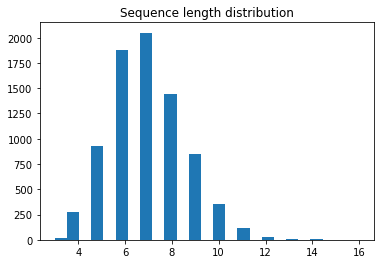

In [5]:
MAX_LENGTH = max(map(len, names))
print("max length =", MAX_LENGTH)

plt.title('Sequence length distribution')
plt.hist(list(map(len, names)),bins=25);

# Text processing

First we need next to collect a "vocabulary" of all unique tokens i.e. unique characters. We can then encode inputs as a sequence of character ids.

In [6]:
#all unique characters go here
tokens = set()

for name in names:
    tokens.update(set(name))

num_tokens = len(tokens)
print ('num_tokens = ', num_tokens)

assert 50 < num_tokens < 60, "Names should contain within 50 and 60 unique tokens depending on encoding"

num_tokens =  55


### Convert characters to integers

Torch is built for crunching numbers, not strings. 
To train our neural network, we'll need to replace characters with their indices in tokens list.

Let's compose a dictionary that does this mapping.

In [11]:
token_to_id = {token: idx for idx, token in enumerate(tokens)}

In [12]:
print(token_to_id)

{'z': 0, 'n': 1, 'T': 2, ' ': 3, 'M': 4, 'r': 5, 'w': 6, 's': 7, 'j': 8, 'V': 9, 'l': 10, 'F': 11, 'U': 12, 'b': 13, 'y': 14, 'q': 15, 'S': 16, 'Y': 17, 'u': 18, 'k': 19, 'O': 20, 'g': 21, 'J': 22, 'E': 23, 'H': 24, 'G': 25, '-': 26, 'v': 27, 'N': 28, 'B': 29, 'R': 30, 'h': 31, 'o': 32, 'A': 33, 'x': 34, "'": 35, 'D': 36, 'X': 37, 'd': 38, 't': 39, 'L': 40, 'I': 41, 'K': 42, 'P': 43, 'Q': 44, 'e': 45, 'W': 46, 'c': 47, 'C': 48, 'f': 49, 'Z': 50, 'a': 51, 'm': 52, 'p': 53, 'i': 54}


In [13]:
token_to_id['a']

51

In [15]:
assert len(tokens) == len(token_to_id), "dictionaries must have same size"
tokens = list(tokens)

for i in range(num_tokens):
    assert token_to_id[tokens[i]] == i, "token identifier must be it's position in tokens list"

print("Seems alright!")

Seems alright!


In [25]:
x = np.zeros([3, 2]) + token_to_id[' ']
print(x)

[[3. 3.]
 [3. 3.]
 [3. 3.]]


In [26]:
def to_matrix(names, max_len=None, pad=token_to_id[' '], dtype='int32', batch_first = True):
    """Casts a list of names into rnn-digestable matrix"""
    
    max_len = max_len or max(map(len, names))
    names_ix = np.zeros([len(names), max_len], dtype) + pad

    for i in range(len(names)):
        line_ix = [token_to_id[c] for c in names[i]]
        names_ix[i, :len(line_ix)] = line_ix
        
    if not batch_first: # convert [batch, time] into [time, batch]
        names_ix = np.transpose(names_ix)

    return names_ix

In [27]:
#Example: cast 4 random names to matrices, pad with zeros
print('\n'.join(names[::2000]))
print(to_matrix(names[::2000]))

 Abagael
 Glory
 Prissie
 Giovanne
[[ 3 33 13 51 21 51 45 10  3]
 [ 3 25 10 32  5 14  3  3  3]
 [ 3 43  5 54  7  7 54 45  3]
 [ 3 25 54 32 27 51  1  1 45]]


# Recurrent neural network

We can rewrite recurrent neural network as a consecutive application of dense layer to input $x_t$ and previous rnn state $h_t$. This is exactly what we're gonna do now.
<img src="./rnn.png" width=480>

Since we're training a language model, there should also be:
* An embedding layer that converts character id x_t to a vector.
* An output layer that predicts probabilities of next phoneme

In [28]:
import torch, torch.nn as nn
import torch.nn.functional as F

In [36]:
class CharRNNCell(nn.Module):
    """
    Implement the scheme above as torch module
    """
    def __init__(self, num_tokens=len(tokens), embedding_size=16, rnn_num_units=64):
        super(self.__class__,self).__init__()
        self.num_units = rnn_num_units
        
        self.embedding = nn.Embedding(num_tokens, embedding_size)
        self.rnn_update = nn.Linear(embedding_size + rnn_num_units, rnn_num_units)
        self.rnn_to_logits = nn.Linear(rnn_num_units, num_tokens)
        
    def forward(self, x, h_prev):
        """
        This method computes h_next(x, h_prev) and log P(x_next | h_next)
        We'll call it repeatedly to produce the whole sequence.
        
        :param x: batch of character ids, containing vector of int64
        :param h_prev: previous rnn hidden states, containing matrix [batch, rnn_num_units] of float32
        """
        # get vector embedding of x
        x_emb = self.embedding(x)
        
        # compute next hidden state using self.rnn_update
        # hint: use torch.cat(..., dim=...) for concatenation
        x_and_h = torch.cat([h_prev, x_emb], dim=1)
        h_next = self.rnn_update(x_and_h)
        
        h_next = torch.tanh(h_next)
        
        assert h_next.size() == h_prev.size()
        
        #compute logits for next character probs
        logits = self.rnn_to_logits(h_next)
        
        return h_next, F.log_softmax(logits, -1)
    
    def initial_state(self, batch_size):
        """ return rnn state before it processes first input (aka h0) """
        return torch.zeros(batch_size, self.num_units, requires_grad=True)

In [37]:
char_rnn = CharRNNCell()
criterion = nn.NLLLoss()

### RNN loop

Once we've defined a single RNN step, we can apply it in a loop to get predictions on each step.

In [38]:
x = torch.tensor([[1, 2, 4], [3, 5, 0]])
print(x.size())
print(x.shape)

torch.Size([2, 3])
torch.Size([2, 3])


In [42]:
for line in x:
    print(line)

tensor([1, 2, 4])
tensor([3, 5, 0])


In [39]:
def rnn_loop(char_rnn, batch_ix):
    """
    Computes log P(next_character) for all time-steps in names_ix
    :param names_ix: an int32 matrix of shape [batch, time], output of to_matrix(names)
    """
    batch_size, max_length = batch_ix.size()
    hid_state = char_rnn.initial_state(batch_size)
    logprobs = []

    for x_t in batch_ix.transpose(0,1):
        hid_state, logp_next = char_rnn(x_t, hid_state)  # <-- here we call your one-step code
        logprobs.append(logp_next)
        
    return torch.stack(logprobs, dim=1)

In [40]:
batch_ix = to_matrix(names[:5])
batch_ix = torch.tensor(batch_ix, dtype=torch.int64)

logp_seq = rnn_loop(char_rnn, batch_ix)

assert torch.max(logp_seq).data.numpy() <= 0
assert tuple(logp_seq.size()) ==  batch_ix.shape + (num_tokens,)

In [41]:
print(logp_seq)

tensor([[[-3.9135, -3.9404, -3.9664,  ..., -3.9264, -3.9355, -4.1219],
         [-4.1208, -4.0763, -3.8523,  ..., -3.9315, -4.3550, -4.0004],
         [-3.8772, -3.9582, -4.0522,  ..., -3.7977, -4.2452, -3.9669],
         ...,
         [-4.0332, -3.8416, -3.6816,  ..., -4.1493, -3.8742, -4.1441],
         [-4.3281, -4.0695, -4.1101,  ..., -3.7786, -4.1483, -4.0245],
         [-3.9274, -4.0581, -4.3314,  ..., -3.5449, -3.7051, -4.1444]],

        [[-3.9135, -3.9404, -3.9664,  ..., -3.9264, -3.9355, -4.1219],
         [-4.1208, -4.0763, -3.8523,  ..., -3.9315, -4.3550, -4.0004],
         [-3.8772, -3.9582, -4.0522,  ..., -3.7977, -4.2452, -3.9669],
         ...,
         [-4.0332, -3.8416, -3.6817,  ..., -4.1493, -3.8742, -4.1441],
         [-4.0833, -4.0594, -4.4161,  ..., -3.7920, -3.6930, -4.1636],
         [-3.8244, -3.9635, -4.2691,  ..., -3.6506, -3.6047, -4.2597]],

        [[-3.9135, -3.9404, -3.9664,  ..., -3.9264, -3.9355, -4.1219],
         [-4.1208, -4.0763, -3.8523,  ..., -3

### Likelihood and gradients

We can now train our neural network to minimize crossentropy (maximize log-likelihood) with the actual next tokens.

To do so in a vectorized manner, we take `batch_ix[:, 1:]` - a matrix of token ids shifted i step to the left so i-th element is acutally the "next token" for i-th prediction

In [43]:
predictions_logp = logp_seq[:, :-1]
actual_next_tokens = batch_ix[:, 1:]

logp_next = torch.gather(predictions_logp, dim=2, index=actual_next_tokens[:,:,None])

loss = -logp_next.mean()

In [44]:
loss.backward()

In [45]:
for w in char_rnn.parameters():
    assert w.grad is not None and torch.max(torch.abs(w.grad)).data.numpy() != 0, \
        "Loss is not differentiable w.r.t. a weight with shape %s. Check forward method." % (w.size(),)

### The training loop

We train our char-rnn exactly the same way we train any deep learning model: by minibatch sgd.

The only difference is that this time we sample strings, not images or sound.

In [47]:
from IPython.display import clear_output
from random import sample

char_rnn = CharRNNCell()
opt = torch.optim.Adam(char_rnn.parameters())
history = []
criterion = nn.NLLLoss()

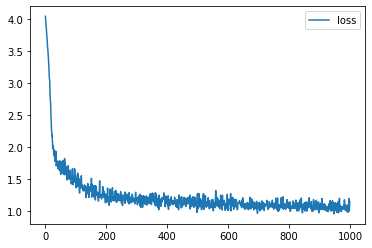

In [48]:
MAX_LENGTH = 16

for i in range(1000):
    opt.zero_grad()
    batch_ix = to_matrix(sample(names, 32), max_len=MAX_LENGTH)
    batch_ix = torch.tensor(batch_ix, dtype=torch.int64)
    
    logp_seq = rnn_loop(char_rnn, batch_ix)
    
    
    predictions_logp = logp_seq[:, :-1, :]
    actual_next_tokens = batch_ix[:, 1:]
    loss = criterion(predictions_logp.contiguous().view(-1, num_tokens), 
                     actual_next_tokens.contiguous().view(-1))
    
    loss.backward()
    opt.step()

    history.append(loss.data.numpy())
    if (i+1)%100==0:
        clear_output(True)
        plt.plot(history,label='loss')
        plt.legend()
        plt.show()

assert np.mean(history[:10]) > np.mean(history[-10:]), "RNN didn't converge."

### RNN: sampling
Once we've trained our network a bit, let's get to actually generating stuff. 
All we need is the single rnn step function you have defined in `char_rnn.forward`.

In [49]:
def generate_sample(char_rnn, seed_phrase=' ', max_length=MAX_LENGTH, temperature=1.0):
    '''
    The function generates text given a phrase of length at least SEQ_LENGTH.
    :param seed_phrase: prefix characters. The RNN is asked to continue the phrase
    :param max_length: maximum output length, including seed_phrase
    :param temperature: coefficient for sampling.  higher temperature produces more chaotic outputs,
                        smaller temperature converges to the single most likely output
    '''
    
    x_sequence = [token_to_id[token] for token in seed_phrase]
    x_sequence = torch.tensor([x_sequence], dtype=torch.int64)
    hid_state = char_rnn.initial_state(batch_size=1)
    
    #feed the seed phrase, if any
    for i in range(len(seed_phrase) - 1):
        hid_state, _ = char_rnn(x_sequence[:, i], hid_state)
    
    #start generating
    for _ in range(max_length - len(seed_phrase)):
        hid_state, logp_next = char_rnn(x_sequence[:, -1], hid_state)
        p_next = F.softmax(logp_next / temperature, dim=-1).data.numpy()[0]
        
        # sample next token and push it back into x_sequence
        next_ix = np.random.choice(num_tokens,p=p_next)
        next_ix = torch.tensor([[next_ix]], dtype=torch.int64)
        x_sequence = torch.cat([x_sequence, next_ix], dim=1)
        
    return ''.join([tokens[ix] for ix in x_sequence.data.numpy()[0]])

In [50]:
for _ in range(10):
    print(generate_sample(char_rnn))

 Roleo          
 Linie          
 Vriyl          
 Dendun         
 Ronapne        
 Culeya         
 Coral          
 Momly          
 Nrirey         
 Rontanorlin    


In [66]:
for _ in range(50):
    print(generate_sample(char_rnn, seed_phrase=' '))

 Kall           
 Shhmassane     
 Coriwete       
 Idonco         
 Eler           
 Aly            
 Lhemtia        
 Maysdho        
 Emoa           
 Nalla          
 Keritta        
  Salia         
 AreliaR        
 Madtata        
 Slosh          
 EDden          
 Idbil          
 Rionan         
 Lagrelo        
 Kethalrie      
 Coleo          
 Lracyna        
 Crirna         
 Mawta M        
 Molsel         
 Lonetdot       
 Kumarta        
 Vianethelle    
  Rene          
 Reney          
 Olleice        
 Tacbon         
 Kort           
 Psery          
 AhIijdg        
 Tamty          
 Ancop          
 Llenlee        
 Damue          
 Iibibs         
 Ihgeelioe      
 Rofie          
 Lyrnebo        
 Dedrendian     
 Lercel         
 Mareetase      
 Ctomin         
 Vholin         
 Morsene        
 Sulynem        


### More seriously

What we just did is a manual low-level implementation of RNN. While it's cool, i guess you won't like the idea of re-writing it from scratch on every occasion. 

As you might have guessed, torch has a solution for this. To be more specific, there are two options:
* `nn.RNNCell(emb_size, rnn_num_units)` - implements a single step of RNN just like you did. Basically concat-linear-tanh
* `nn.RNN(emb_size, rnn_num_units` - implements the whole rnn_loop for you.

There's also `nn.LSTMCell` vs `nn.LSTM`, `nn.GRUCell` vs `nn.GRU`, etc. etc.

In this example we'll rewrite the char_rnn and rnn_loop using high-level rnn API.

In [67]:
class CharRNNLoop(nn.Module):
    def __init__(self, num_tokens=num_tokens, emb_size=16, rnn_num_units=64):
        super(self.__class__, self).__init__()
        self.emb = nn.Embedding(num_tokens, emb_size)
        self.rnn = nn.RNN(emb_size, rnn_num_units, batch_first=True)
        self.hid_to_logits = nn.Linear(rnn_num_units, num_tokens)
        
    def forward(self, x):
        assert isinstance(x.data, torch.LongTensor)
        h_seq, _ = self.rnn(self.emb(x))
        next_logits = self.hid_to_logits(h_seq)
        next_logp = F.log_softmax(next_logits, dim=-1)
        return next_logp
    
model = CharRNNLoop()
opt = torch.optim.Adam(model.parameters())
history = []

In [68]:
# the model applies over the whole sequence
batch_ix = to_matrix(sample(names, 32), max_len=MAX_LENGTH)
batch_ix = torch.LongTensor(batch_ix)

logp_seq = model(batch_ix)

# compute loss. 
loss = F.nll_loss(logp_seq[:, 1:].contiguous().view(-1, num_tokens), 
                  batch_ix[:, :-1].contiguous().view(-1))

loss.backward()

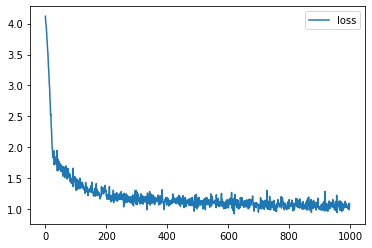

In [69]:
MAX_LENGTH = 16

for i in range(1000):
    opt.zero_grad()
    batch_ix = to_matrix(sample(names, 32), max_len=MAX_LENGTH)
    batch_ix = torch.tensor(batch_ix, dtype=torch.int64)
    
    logp_seq = model(batch_ix)    
    
    predictions_logp = logp_seq[:, :-1, :]
    actual_next_tokens = batch_ix[:, 1:]
    loss = criterion(predictions_logp.contiguous().view(-1, num_tokens), 
                     actual_next_tokens.contiguous().view(-1))
    
    # train with backprop
    loss.backward()
    opt.step()
    
    history.append(loss.data.numpy())
    if (i+1)%100==0:
        clear_output(True)
        plt.plot(history,label='loss')
        plt.legend()
        plt.show()

assert np.mean(history[:10]) > np.mean(history[-10:]), "RNN didn't converge."

In [71]:
def generate_sample(char_rnn, seed_phrase=' ', max_length=MAX_LENGTH, temperature=1.0):
    '''
    The function generates text given a phrase of length at least SEQ_LENGTH.
    :param seed_phrase: prefix characters. The RNN is asked to continue the phrase
    :param max_length: maximum output length, including seed_phrase
    :param temperature: coefficient for sampling.  higher temperature produces more chaotic outputs,
                        smaller temperature converges to the single most likely output
    '''
    
    x_sequence = [token_to_id[token] for token in seed_phrase]
    x_sequence = torch.tensor([x_sequence], dtype=torch.int64)
    hid_state = char_rnn.rnn.initial_state(batch_size=1)
    
    #feed the seed phrase, if any
    for i in range(len(seed_phrase) - 1):
        hid_state, _ = char_rnn(x_sequence[:, i], hid_state)
    
    #start generating
    for _ in range(max_length - len(seed_phrase)):
        hid_state, logp_next = char_rnn(x_sequence[:, -1], hid_state)
        p_next = F.softmax(logp_next / temperature, dim=-1).data.numpy()[0]
        
        # sample next token and push it back into x_sequence
        next_ix = np.random.choice(num_tokens,p=p_next)
        next_ix = torch.tensor([[next_ix]], dtype=torch.int64)
        x_sequence = torch.cat([x_sequence, next_ix], dim=1)
        
    return ''.join([tokens[ix] for ix in x_sequence.data.numpy()[0]])

In [78]:
for _ in range(10):
    model(torch.LongTensor(3))

IndexError: index out of range in self

### To sum up:
- PyTorch is convenient both for prototyping and production
- There are a lot of pre-implemented methods/layers/activations out of the box
- It's much easier (*really easier*) to use PyTorch than TensorFlow on entry level. 
- Neural networks are not *black boxes*, they are pretty nice and easy to use (almost always).

### Try it out!
You've just implemented a recurrent language model that can be tasked with generating any kind of sequence, so there's plenty of data you can try it on:

* Novels/poems/songs of your favorite author
* News titles/clickbait titles
* Source code of Linux or Tensorflow
* Molecules in [smiles](https://en.wikipedia.org/wiki/Simplified_molecular-input_line-entry_system) format
* Melody in notes/chords format
* Ikea catalog titles
* Pokemon names
* Cards from Magic, the Gathering / Hearthstone

If you're willing to give it a try, here's what you wanna look at:
* Current data format is a sequence of lines, so a novel can be formatted as a list of sentences. Alternatively, you can change data preprocessing altogether.
* While some datasets are readily available, others can only be scraped from the web. Try `Selenium` or `Scrapy` for that.
* Make sure MAX_LENGTH is adjusted for longer datasets. There's also a bonus section about dynamic RNNs at the bottom.
* More complex tasks require larger RNN architecture, try more neurons or several layers. It would also require more training iterations.
* Long-term dependencies in music, novels or molecules are better handled with LSTM or GRU

__Good hunting!__